# 15688 Practical Science Tutorial
## ——Weather data processing and forecasting

This tutorial aims to apply data science in building models to predict weather temperature. The data is collected from Weather Underground and it is free to access by its API web service. After collected, the data must be transformed into a format, in this tutorial, pkl file, and then cleaned.

This tutorial focuses on building a Linear Regression(LR) model to reveal the trends in the data. The key of constructing a robust LR model is how to select appropriate features and properly evaluate them. Two important libraries [Scikit-Learn](http://scikit-learn.org/) and [StatsModels](http://www.statsmodels.org/) will be used in this tutorial.

### Get data from the API

In this part, I implementED the API to obtain the data.

First of all, I registered a user(https://www.wunderground.com/weather/api) for the API, which is utilized for the parse permition. Secondly, I set the information of state and city for filter the location. The format is represents as follow:
http://api.wunderground.com/api/KEY/history_YYYYMMDD/q/state/city.json
  -  KEY: the Weather Underground provides the key with your account
  -  YYYYMMDD: a string representing the target date of your request
  -  state: the two-letter state abbreviation in the United States
  -  city: the name of the city associated with the state you requested  
  
Finally, I designed a parse pattern, since the website has a lot of data. The websites provides many different API's to access data from, but what I concerned is the history weather API. By collecting a lot of historic data, I could infer some conclusion by modelling the history data. And this API provides a summary of various weather measurements for a city and state on a specific day. I need to select the records whose types are related to my weather prediction.

After having the API_KEY, I could parse the url. In this tutorial, I will parse the weather data of pittsburgh, and the state is PA. By now, I know everything except the date. Therefore, the base_url could be written to a string with a place holder. The base url is obtained:

http://api.wunderground.com/api/{}/history_{}/q/PA/pittsburgh.json

the first {} is the API_KEY, my API is 97dd52ed89736e38. The second {} is the waiting for the date. I decided to parse one year data of Pittsburgh. From 01/01/2017 to 01/01/2018.

### Import libraries

Before starting the project, I need to make sure the libraries I will be using have been installed. For installation instructions please refer to the listed documentation.

In [231]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from collections import namedtuple
import pandas as pda
import requests
import matplotlib.pyplot as plt

### Getting Smaple Data

Since the whole tutorial is based on the weather data, I decided to obtain one day data so that I could specify the features that I would like to parse and finally use.

In [257]:
BASE_URL = "http://api.wunderground.com/api/97dd52ed89736e38/history_{}/q/PA/pittsburgh.json"
target_date = datetime(2017, 1, 1)
request = BASE_URL.format(target_date.strftime('%Y%m%d'))
response = requests.get(request)
if response.status_code == 200:
    data = response.json()['history']['dailysummary'][0]  
print(data)

{'date': {'pretty': '12:00 PM EST on January 01, 2017', 'year': '2017', 'mon': '01', 'mday': '01', 'hour': '12', 'min': '00', 'tzname': 'America/New_York'}, 'fog': '0', 'rain': '1', 'snow': '0', 'snowfallm': '0.00', 'snowfalli': '0.00', 'monthtodatesnowfallm': '', 'monthtodatesnowfalli': '', 'since1julsnowfallm': '', 'since1julsnowfalli': '', 'snowdepthm': '', 'snowdepthi': '', 'hail': '0', 'thunder': '0', 'tornado': '0', 'meantempm': '3', 'meantempi': '38', 'meandewptm': '-2', 'meandewpti': '29', 'meanpressurem': '1020', 'meanpressurei': '30.12', 'meanwindspdm': '14', 'meanwindspdi': '9', 'meanwdire': '', 'meanwdird': '255', 'meanvism': '15', 'meanvisi': '9', 'humidity': '', 'maxtempm': '7', 'maxtempi': '44', 'mintempm': '0', 'mintempi': '32', 'maxhumidity': '89', 'minhumidity': '51', 'maxdewptm': '1', 'maxdewpti': '33', 'mindewptm': '-4', 'mindewpti': '25', 'maxpressurem': '1026', 'maxpressurei': '30.29', 'minpressurem': '1012', 'minpressurei': '29.90', 'maxwspdm': '24', 'maxwspdi': 

From the sample parsing data, I found out that there are a lot of variables, but I only need to choose a part of them which may affect weather. The features I decided to use is "date", "meantempm", "meandewptm", "meanpressurem", "maxhumidity", "minhumidity", "maxtempm","mintempm", "maxdewptm", "mindewptm", "maxpressurem", "minpressurem", "precipm","gdegreedays","meanwdire", "meanvism","maxvism", and "minvism".

### Obtain Batch Data
I could collect one year's weather data now. Pay attention, the free account provides an API key to access the web service at a rate of 10 requests per minute and up to a total of 500 requests in a day. Therefore, we should set the sleep time 60/10 = 6.

In [258]:
records = []
days = 365
features = ["date", "meantempm", "meandewptm", "meanpressurem", "maxhumidity", "minhumidity", "maxtempm",
            "mintempm", "maxdewptm", "mindewptm", "maxpressurem", "minpressurem", "precipm"]
DailySummary = namedtuple("DailySummary", features)
for i in range(days):
    # fill the base_url
    request = BASE_URL.format(target_date.strftime('%Y%m%d'))
    # get and confirm the request
    response = requests.get(request)
    if response.status_code == 200:
        data = response.json()['history']['dailysummary'][0]
        tmp = DailySummary(
            date=target_date,
            meantempm=data['meantempm'],
            meandewptm=data['meandewptm'],
            meanpressurem=data['meanpressurem'],
            maxhumidity=data['maxhumidity'],
            minhumidity=data['minhumidity'],
            maxtempm=data['maxtempm'],
            mintempm=data['mintempm'],
            maxdewptm=data['maxdewptm'],
            mindewptm=data['mindewptm'],
            maxpressurem=data['maxpressurem'],
            minpressurem=data['minpressurem'],
            precipm=data['precipm'])
        records.append(tmp)
    # set sleep time
    time.sleep(6)
    # move on the next day 
    target_date = target_date + timedelta(days = 1)

In [290]:
df = pd.DataFrame(records, columns=features).set_index('date')

### Data cleaning

The most important part of analytics projects is to make sure the data is qualified. However, data cleaning is of great significance, while it is also time-consuming and laborious. In this tutorial, I tried to identify unnecessary data, missing values, consistency of data types, etc.

First, I looped over the features which were put into the feature list earlier, for each feature that is not date feature, I made three new colmns for that feature representing the Nth prior day's measurement, where $N = 1, 2, 3$. By doing this, I got four times of the number of original features, for example, for meantempm, I now have meantempm, meantmpm_1, meantempm_2, and meantempm_3 and I could make better predictions.

In [291]:
for feature in features:
    if feature != 'date':
        for N in range(1, 4):
            rows = df.shape[0]
            n_prior = [None]*N + [df[feature][i-N] for i in range(N, rows)]
            col_ = "{}_{}".format(feature, N)
            df[col_] = n_prior

In [292]:
to_remove = []
for feature in features:
    if feature not in ['meantempm', 'mintempm', 'maxtempm']:
        to_remove.append(feature)

df = df[[col for col in df.columns if col not in to_remove]]
df = df.apply(pd.to_numeric, errors='coerce')
for precip_col in ['precipm_1', 'precipm_2', 'precipm_3']:
    lost_val = pd.isnull(df[precip_col])
    df[precip_col][lost_val] = 0
df = df.dropna()
#df.info()

import pickle
with open('weather_data.pkl', 'wb') as fp:
    pickle.dump(df, fp)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [293]:
import pickle
with open('weather_data.pkl', 'rb') as fp:
    df = pickle.load(fp)

### Select features for LR model

Linear regression is a linear approach to modelling the relationship between one dependent variable(y, in this case, the temperature) and one or more independent variables(X, in this case, the feature vector). Using LR model can help us to predict the value of corresponding temperature when given the features.

In order to build an appropriate Linear Regression model, whether there is a linear relationship between the dependent variable and each of the independent variables needs to be figured out. I decided to use correlation coefficient to judge the linearity between different features and the dependent variable, then select those features with higher coefficient. The Pearson correlation coefficient is a measure of the linear correlation between two variables, it has a value between +1 and -1. 0 means the two variables have no linear correlation. value between 0 and 1 shows positive linear correlation while value ranging from -1 to 0 means negative linear relationship. Coefficient value with higher absolute value shows that the linear correaltion is stronger. By calling corr() method the correlation coeffiecients can be easily calculated. Then I sorted all the coefficient values so that the strength of correlation relationship can be more obvious.

In [294]:
tmp = df.corr(method = 'pearson')[['meantempm']]
#print(tmp)

In [295]:
tmp = tmp.sort_values(by = 'meantempm', axis = 0, ascending = False)
#print(tmp)

In this tutorial, I classified the value of coefficients into five different degree, they are very weak, weak, moderate, strong and very strong, each degree takes 20% of the total value. In order to select the most appropriate and representative features, I only chose those classified as very strong degree, in another words, the correlation coefficients between mean temperature and these features are between 0.8 and 1. Among all the features above, I removed all temperature features and kept the remaing 9 features, created a new DataFrame using these 9 features together with the Y variable, mean temperature.

In [296]:
features_col = ['meantempm_1', 'maxtempm_1','mintempm_1', 'mindewptm_1',
                'meandewptm_1', 'meantempm_2', 'maxdewptm_1', 'maxtempm_2',
                'mintempm_2']
new_df = df[['meantempm'] + features_col]
#print(new_df)

### Visualiaze the linear relationships

Visualization is a common way to help understand data more intuitively by  creating images, diagrams, or animations. Though knowing these selected features may have strong positive linear relationship with the mean temperature, the potential relationships can be better proved by plotting each of the features with the dependent variable. In order to compare the relatives, let the dependent variable to be the fixed axis, and plot the 9 features seperately, thus 9 plots can be obtained.

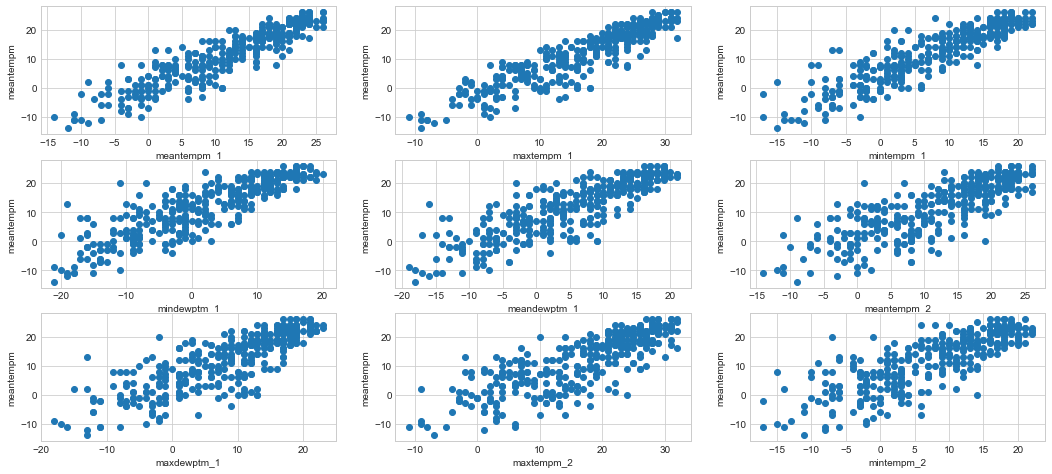

In [297]:
features = np.array(features_col)
features = features.reshape(3, 3)
#print(features)
plt.figure()
for row, col_ in enumerate(features):
    for col, feature in enumerate(col_):
        plt.subplot(3, 3, row * 3 + col + 1)
        plt.scatter(new_df[feature], new_df['meantempm'])
        plt.xlabel(feature)
        plt.ylabel('meantempm')
plt.show()

### Apply step-wise regression

Although calculating Pearson correlation coefficient can help extract proper features and reduce the amount of variables, the predictors for a robust LR model requires to be meaningful and statistically significant. Python provides a library statsmodels to offer classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration, which is applied in this tutorial.

Since I have already selected 9 features from a bunch of related variables, I could validate the robustness of the model build with these variables, and set up a fixed evaluation criteria to judge whether the current model is robust enough. However, the interactions between vsriables cannot be ignored, if they interacted with each other, the result may be highly effected and leads to a wrong hypothesis. Under this assumption, I prefer to use step-wise regression to test for each different variable and decide whether it needs to be removed from the feature sets. Step-wise regression is an efficient method to evaluate the statistical significance of each variable in the model. In this tutorial, I introduced backward elimination, whose process is like below:
1. Select a significance level $\alpha$
2. Fit the model with all selected features
3. Use the p-value to evaluate features, if the one with greatest p-value has a p-value which is above the significant value, remove it, repeat step 2 and step 3 until all the p-values are below the significant value
4. obtain the final model

It's also important to note that the statsmodels does not add a constant by default, so I set it by using the add_constant() method, where the parameter will be the name of the data frame containing the independent variables, i.e., the features.

In [298]:
import statsmodels.api as sm
ols_X_df = new_df[features_col]
ols_y_df = new_df['meantempm']
#print(ols_X_df)
#print(ols_y_df)
ols_X_df = sm.add_constant(X_df)
model = sm.OLS(ols_y_df, ols_X_df).fit()
# make the predictions by the model
ols_predictions = model.predict(ols_X_df)
# print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              meantempm   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     273.1
Date:                Fri, 30 Mar 2018   Prob (F-statistic):          6.93e-153
Time:                        23:39:20   Log-Likelihood:                -951.71
No. Observations:                 362   AIC:                             1923.
Df Residuals:                     352   BIC:                             1962.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3686      0.749      1.827      0.069      -0.105       2.842
meantempm_1     -0.9103      0.402     -2.262      0.024      -1.702      -0.119
maxtempm_1       1.1430      0.203      5.627      0.000       0.743       1.543
mintempm_1       0.8268      0.217      3.810      0.000       0.400       1.254
mindewptm_1      0.2396      0.105      2.287      0.023       0.034       0.446
meandewptm_1     0.0008      0.213      0.004      0.997      -0.419       0.420
meantempm_2     -0.3429      0.394     -0.870      0.385      -1.118       0.433
maxdewptm_1     -0.3745      0.144     -2.601      0.010      -0.658      -0.091
maxtempm_2       0.0712      0.212      0.336      0.737      -0.346       0.488
mintempm_2       0.1978      0.207      0.956      0.340      -0.209       0.604
==============================================================================
Omnibus:                       19.675   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.965
Skew:                          -0.430   Prob(JB):                     1.40e-06
Kurtosis:                       4.024   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Interpreting the table__ 

This is a very long table. On the top of the table, there are depedent variable mean temperature, the model OLS, which stands for Ordinary Least Squares and method least squares means that the model is trying to fit a regression line that would minimize the square of distance from the regression line, df rediduals and df model relates to the degrees of freedom.

Since the major task is comparing the differences between the results of different variables, I planed to focus on the major two values in this tutorial:
1. R-squared and Adj.R-squared -- R-squared is a measure that states the percentage of variance, Adj.R-squared is similar to R-squared, but for multiple linear regression this value has a penalty applied to it based on the number of variables being included, it is mainly to explain the level of overfitting
2. P>|t| -- P>|t| is the p-value I used to evaluate the hypothesis in this tutorial. If one variable has a p-value which is the greatest among all the p-values and is greater than the fixed $\alpha$ I set, which is 0.05, than I would eliminate the variable.

Other values in the table are of great significance as well, for example, coefficient, the standard error, which is the standard deviation of the sampling distribution of a statistic, most commonly of the mean, and so on. However, limited by the space, the focus should be put on the above two values.

Initially, I put all 9 features into the X vector and fit the model, it can be concluded easily that meandewptm_1 has the greatest p-value of 0.997, and the p-value is also greater then the threshold of 0.05, thus I removed the meandewptm_1 feature this time.

In [299]:
ols_X_df = ols_X_df.drop('meandewptm_1', axis = 1)
#print(ols_X_df)
model = sm.OLS(ols_y_df, ols_X_df).fit()
ols_predictions = model.predict(ols_X_df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              meantempm   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     308.1
Date:                Fri, 30 Mar 2018   Prob (F-statistic):          3.83e-154
Time:                        23:39:21   Log-Likelihood:                -951.71
No. Observations:                 362   AIC:                             1921.
Df Residuals:                     353   BIC:                             1956.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3683      0.742      1.845      0.066      -0.091       2.827
meantempm_1    -0.9105      0.398     -2.286      0.023      -1.694      -0.127
maxtempm_1      1.1431      0.201      5.674      0.000       0.747       1.539
mintempm_1      0.8269      0.213      3.885      0.000       0.408       1.246
mindewptm_1     0.2399      0.067      3.573      0.000       0.108       0.372
meantempm_2    -0.3430      0.393     -0.873      0.383      -1.116       0.430
maxdewptm_1    -0.3741      0.064     -5.876      0.000      -0.499      -0.249
maxtempm_2      0.0712      0.211      0.337      0.736      -0.345       0.487
mintempm_2      0.1978      0.206      0.959      0.338      -0.208       0.604
==============================================================================
Omnibus:                       19.671   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.959
Skew:                          -0.430   Prob(JB):                     1.40e-06
Kurtosis:                       4.024   Cond. No.                         174.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Interpreting the table__ 

After removing meandewptm_3, two major situations occurred on the p-value of other variables: one is no change, the other is slightly change. In this table, meandewptm_2 has the greatest p-value 0.930, it is still greater than 0.05. To avoid too much repitition in this tutorial, I would do the following operation in the next cell and not display the output of any temporary models.

In [300]:
ols_X_df = ols_X_df.drop('maxtempm_2', axis = 1)     # p-value = 0.736
ols_X_df = ols_X_df.drop('mintempm_2', axis = 1)     # p-value = 0.194
ols_X_df = ols_X_df.drop('meantempm_2', axis = 1)    # p-value = 0.078

model = sm.OLS(ols_y_df, ols_X_df).fit()
ols_predictions = model.predict(ols_X_df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              meantempm   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     489.3
Date:                Fri, 30 Mar 2018   Prob (F-statistic):          4.63e-157
Time:                        23:39:22   Log-Likelihood:                -954.22
No. Observations:                 362   AIC:                             1920.
Df Residuals:                     356   BIC:                             1944.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.6926      0.639      1.083      0.279      -0.565       1.950
meantempm_1    -0.9651      0.397     -2.434      0.015      -1.745      -0.185
maxtempm_1      1.1483      0.201      5.705      0.000       0.752       1.544
mintempm_1      0.8100      0.213      3.806      0.000       0.392       1.229
mindewptm_1     0.2432      0.065      3.718      0.000       0.115       0.372
maxdewptm_1    -0.3829      0.063     -6.061      0.000      -0.507      -0.259
==============================================================================
Omnibus:                       16.753   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.168
Skew:                          -0.371   Prob(JB):                     9.31e-06
Kurtosis:                       3.992   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Interpreting the table__ 

I recorded the greatest p-value of each iteration and found out that the greatest p-value is always decreasing, in the end, all the p-values are below the fixed $\alpha$ value 0.05. Meanwhile, after the step-wise regression, the number of features decreased from 9 to 5.

The other value I paied close attention to is the R-squared and Adj.R-squared, the value of R-squared and Adj.R-squared are 0.873 and 0.871, pretty similar, which means that this model has little possibility of overfitting and explains about 87% of the observed variation in the dependent variable.

In [301]:
print(ols_predictions)

date
2017-01-03     3.108244
2017-01-04     6.981042
2017-01-05    -2.214546
2017-01-06    -5.358183
2017-01-07    -9.383700
2017-01-08    -8.050584
2017-01-09    -8.581216
2017-01-10    -4.189029
2017-01-11     0.433739
2017-01-12     7.206857
2017-01-13     8.197649
2017-01-14    -0.436908
2017-01-15    -0.864036
2017-01-16    -0.848208
2017-01-17    -1.203944
2017-01-18     9.083561
2017-01-19     5.691942
2017-01-20     5.680888
2017-01-21     6.795101
2017-01-22    12.315320
2017-01-23    13.170032
2017-01-24     4.271149
2017-01-25     3.244612
2017-01-26     7.605599
2017-01-27     2.731481
2017-01-28    -0.376410
2017-01-29     0.344747
2017-01-30    -0.723123
2017-01-31    -3.468009
2017-02-01    -1.424422
                ...    
2017-12-01     9.007789
2017-12-02     5.193262
2017-12-03     4.067707
2017-12-04     6.730611
2017-12-05     9.953446
2017-12-06     2.081062
2017-12-07     4.140565
2017-12-08     0.380493
2017-12-09    -5.578264
2017-12-10    -2.300102
2017-12-11 

### Apply gradient descent

To produce predictions, there are lots of various approaches besides the above simple ordinary squares model OLS Statsmodels, in this tutorial, I would like to realize another common method, gradient descent. Instead of directly using the stochastic gradient descent regression SGDRegression Scikit Learn, I tried to implement the process of gradient descent without the help of libraries.

__Step1  Normalize the features__

Normalizing the features amis to get all the data on the same scale. If the scales for different features are widly different, this can have a knock-on effect on learning ability. In that case, ensuaring standardised feature values implicitly weights all features equally in their representation.

In [302]:
f_df = new_df[features_col]   # features
t_df = new_df['meantempm']    # target
mu = f_df.mean()
sigma = f_df.std()
n_f_df = (f_df - mu) / sigma
#print(n_f_df)
#print(mu)
#print(sigma)

__Step2 Initialize the parameters__

To make the calculation more convenient, I converted the Pandas DataFrame feature dataframe f_df and target fataframe t_df to numpy arrays. In gradient descent, the size of the steps to take is called the learning rate, often represented by $\alpha$. With a high learning rate the process can cover more ground each step, but it is risky of overshooting the lowest point since the slope of the hill is constantly changing. However, with a very low learning rate, the calculation of gradient descent may be very time-comsuming though it may be more precise. To balance both situation, I chose $\alpha$ as 0.1, and set the number of iteration as 50.

In [303]:
n_f_df['ones'] = np.ones(len(t_df))
#print(n_f_df)
f_arr = np.array(n_f_df)
t_arr = np.array(t_df)
#print(f_arr)
#print(t_arr)
alpha = 0.1
num_iter = 50

__Step3 Gradient descent__

For linear regression, the hypothesis function is $h_{\theta}(x_{1}, x_{2}, ..., x_{n}) = \theta_{0} + \theta_{1}x_{1} + ... + \theta_{n}x_{n}$, where $\theta_{i}(i = 0,1,2,...,n)$ is the model parameter, $x_{i}(i = 0,1,2,...,n)$ is the feature vector of data. I initialized all the $\theta$ as zero, and adjust the value of $\theta$ in each iteration. Below is the process for each iteration:

1. Calculate the gradient of the current position
2. Update the value of $\theta$ according to the fixed $\alpha$ and calculated $\delta$
3. Calculate the sum of squared error, the loss function is $J(\theta_{0}, \theta_{1}, ..., \theta_{n}) = \frac{1}{2n}\sum^{n}_{i=0}(h_{\theta}(x^{i}_{0}, x^{i}_{1}, ..., x^{i}_{n}) - y_{i})^{2}$
4. Put the cost into the cost history array, this history array is used to record the whole iteration process
5. Repeat Step1 to Step4 until there are enough iterations

In [304]:
history = []
length = len(t_arr)
theta = np.zeros(len(n_f_df.columns))
for i in range(num_iter):
    delta = (np.dot((t_arr - np.dot(f_arr, theta)), f_arr)) / length
    theta = theta + alpha * delta
    sum_square_err = np.square(np.dot(f_arr, theta) - t_arr).sum()
    cost = sum_square_err / (2 * length)
    history.append(cost)
#print(theta)
#print(history)

__Step4 Make predictions__

Knowing the value of $\theta$, predictions can be made by multipying the feature array and the $\theta$ value.

In [305]:
gd_predictions = np.dot(f_arr, theta)
print(gd_predictions)

[  5.98681198   8.55750175   0.61208154  -4.91286095  -8.50949936
  -8.68669995  -9.11232747  -6.64146136   1.75509689   8.18015145
  10.65448697   0.99899929   0.72588377   0.10532834   1.50636409
   9.67051774   7.21471741   4.89725757   7.82151907  12.30176129
  12.51656767   6.56685092   4.37127629   7.70599183   5.7424689
   0.33190166   0.36318333  -0.13826051  -2.53416563   0.15765909
   2.53547653  -0.99771891  -3.89645169  -3.95006967   1.75590361
   6.19398151  12.0377506    6.6809943   -3.00149165  -2.70888704
   6.95036      7.20745062   1.80043816   3.75219286   2.29785686
  -2.01010196   3.71118176  11.8890689   11.76555756   9.56491101
  12.69109781  13.66910757  15.76442359  17.86921339   7.79253556
   1.06394645   3.48586679   8.85449337   9.84810958   1.11150289
  -1.99796242  -1.85127454  -0.0272067    7.12671069  10.92824338
   7.0333824    6.83725443  -1.54954198  -4.75956211  -3.90325437
  -0.67165536  -2.05676077  -4.78394518  -1.11655408   0.58793519
   4.383937

__Step5 Visualize__

In order to make the accuracy of the predictions more intuitive, I plotted the differences between the observed values and the estimated values in a histogram.

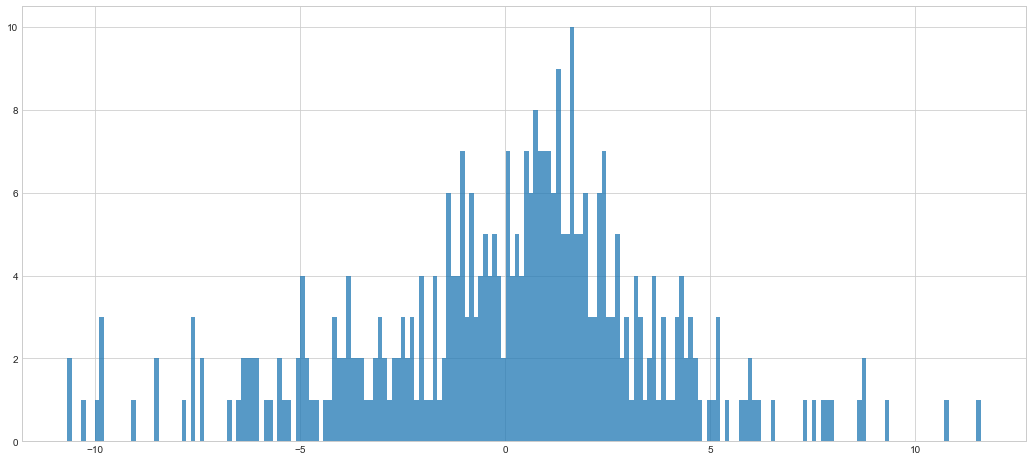

In [306]:
tmp = new_df['meantempm'] - gd_predictions
plt.style.use('seaborn-whitegrid')
plt.hist(tmp, bins=200, alpha = 0.75)
plt.show()

__Step6 Calculate coefficient, $R^{2}$__

The statsmodel provides the value of coefficient, $R^{2}$, and so on, in this step, I calculated the coefficients for each feature and used sklearn and scipy to calculate the value of $R^2$.

In [307]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import linregress
print(theta) # coefficients
print(r2_score(new_df['meantempm'], gd_predictions)) # sklearn.metrics
slope, intercept, r_value, p_value, std_err = linregress(new_df['meantempm'], gd_predictions)
print(r_value**2) #scipy.stats

[ 2.33353999  3.10121458  1.85364319  1.31896234  0.37294288  0.0289433
 -0.45716668  0.02969773  0.14181022 12.04808246]
0.8501215700400303
0.8505362015040713


In this model, the value of $\theta$ is the coefficient, and the two libraries I used in calculating the value of $R^2$ led to pretty similar result, around 0.85.

### Conclusion

In this tutorial, I demonstrated how to use the Linear Regression model to predict future mean temperatures based on the weather data collected from the website Weather Underground using API. After collecting data, I did some initial cleaning steps to obtain qualified data, which ensures that the follow-up modelling and predicting. Later, I calculated the correlation coefficient of each feature in order to select more related features as predictors. However, this is not enough. In order to make robust predictions, I realized two common linear regression modelling methods. One is using statsmodel library and build an OLS model, the other is applying gradient descent and let the model converge to the best situation.

To clearly represent the results and make it easier for people to compare and judge, I took two major measures, calculating the coefficients, $R^{2}$, and so on to picture the model, meanwhile, plot out the histogram and use visualization to make an impress. The results of both methods turn out to be similar, and both models have high accuracy.